In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import linear_model
from sklearn import model_selection

In [5]:
conjuntoDadosSujo = pd.read_csv('DadosPrecoComputadores.csv')
conjuntoDadosSujo.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)
conjuntoDadosSujo.shape

(893, 16)

In [6]:
def transformarColunaOneHotEncode(conjuntoDados, coluna):
    classes = conjuntoDados[coluna].unique()
    dadosOneHotEncode = pd.DataFrame(0, index=range(conjuntoDados.shape[0]), columns=classes)
    for i in classes:
        dadosOneHotEncode[i] = np.where(conjuntoDados[coluna] == i, 1, 0)
    return pd.concat([conjuntoDados.drop(coluna, axis=1), dadosOneHotEncode], axis=1)

def transformarConjuntoOneHotEncode(conjuntoDados, colunas):
    for coluna in colunas:
        conjuntoDados = transformarColunaOneHotEncode(conjuntoDados, coluna)
    return conjuntoDados

def contarCategoriasemVariavel(conjuntoDados, colunas):
    for coluna in colunas:
        print(conjuntoDados[coluna].value_counts(),"\n\n")

def unificarCategorias(conjuntoDados, coluna, categorias):
    for categoria in categorias:
        conjuntoDados.loc[conjuntoDados[coluna] == categoria, coluna] = coluna+"Outros"

Podemos notar que no conjunto de dados há várias variáveis como categoria ou até mesmo texto, havendo poucos do tipo quantitativo, apenas price e spec_rating podendo tratar os outros numéricos como sendo ordinais.

In [7]:
conjuntoDadosSujo.head(5)

,brand,name,price,spec_rating,processor,CPU,Ram,Ram_type,ROM,ROM_type,GPU,display_size,resolution_width,resolution_height,OS,warranty
0,HP,Victus 15-fb0157AX Gaming Laptop,49900,73.000000,5th Gen AMD Ryzen 5 5600H,"Hexa Core, 12 Threads",8GB,DDR4,512GB,SSD,4GB AMD Radeon RX 6500M,15.6,1920.0,1080.0,Windows 11 OS,1
1,HP,15s-fq5007TU Laptop,39900,60.000000,12th Gen Intel Core i3 1215U,"Hexa Core (2P + 4E), 8 Threads",8GB,DDR4,512GB,SSD,Intel UHD Graphics,15.6,1920.0,1080.0,Windows 11 OS,1
2,Acer,One 14 Z8-415 Laptop,26990,69.323529,11th Gen Intel Core i3 1115G4,"Dual Core, 4 Threads",8GB,DDR4,512GB,SSD,Intel Iris Xe Graphics,14.0,1920.0,1080.0,Windows 11 OS,1
3,Lenovo,Yoga Slim 6 14IAP8 82WU0095IN Laptop,59729,66.000000,12th Gen Intel Core i5 1240P,"12 Cores (4P + 8E), 16 Threads",16GB,LPDDR5,512GB,SSD,Intel Integrated Iris Xe,14.0,2240.0,1400.0,Windows 11 OS,1
4,Apple,MacBook Air 2020 MGND3HN Laptop,69990,69.323529,Apple M1,Octa Core (4P + 4E),8GB,DDR4,256GB,SSD,Apple M1 Integrated Graphics,13.3,2560.0,1600.0,Mac OS,1


In [8]:
# Não há valores faltantes no conjunto de dados
conjuntoDadosSujo.isnull().sum()

brand                0
name                 0
price                0
spec_rating          0
processor            0
CPU                  0
Ram                  0
Ram_type             0
ROM                  0
ROM_type             0
GPU                  0
display_size         0
resolution_width     0
resolution_height    0
OS                   0
warranty             0
dtype: int64

In [9]:
colunasContarCategorias = ['brand', 'processor', 'CPU', 'Ram', 'Ram_type', 
                           'ROM', 'ROM_type', 'GPU', 'OS', 'display_size',
                           'resolution_width', 'resolution_height']
contarCategoriasemVariavel(conjuntoDadosSujo, colunasContarCategorias)

brand
HP           186
Lenovo       169
Asus         157
Dell         107
Acer          84
MSI           65
Samsung       28
Apple         16
Infinix       15
LG             9
Xiaomi         8
Gigabyte       8
Fujitsu        6
Zebronics      4
Ultimus        4
Tecno          3
Wings          3
Chuwi          3
Realme         3
Microsoft      2
AXL            2
Huawei         2
Honor          2
Walker         1
Vaio           1
Avita          1
Primebook      1
Ninkear        1
Razer          1
iBall          1
Name: count, dtype: int64 


processor
12th Gen Intel Core i5 1235U     49
13th Gen Intel Core i5 1335U     41
12th Gen Intel Core i3 1215U     38
11th Gen Intel Core i3 1115G4    36
12th Gen Intel Core i5 12450H    33
                                 ..
5th Gen AMD Ryzen 7  5825U        1
6th Gen AMD Ryzen 9  6900HX       1
12th Gen Intel Core i5 1230U      1
AMD Ryzen 3 7320U                 1
13th Gen ‎Intel Core i3 1315U     1
Name: count, Length: 184, dtype: int64 


CPU
Qua

Com as categorias das variáveis contadas, podemos tirar algumas conclusões:
- Na variável representando sistema operacional, tivemos duas formas diferentes para representar o mesmo item, isso acontecendo mais de uma vez, isso foi então arrumado, outra mudança feita foi definir os diferentes sistemas mac como um único.
- Boa parte das variáveis tem algumas categorias muito frequentes, enquanto o resto aparece poucas vezes. Foi colocada essa minoria em apenas uma categoria.

Vamos então usar colunas para representar cada categoria, assim tiramos algo de texto para numérico. A ideia é deixar o conjunto de dados com muita coluna e então usar um modelo simples e regularizado para que possa usar toda a informação necessária e consiga generalizar.

In [10]:
conjuntoDadosSujo.loc[conjuntoDadosSujo['OS'] == 'Windows 10  OS', 'OS'] = "Windows OS"
conjuntoDadosSujo.loc[conjuntoDadosSujo['OS'] == 'Windows 11 OS', 'OS'] = "Windows OS"
conjuntoDadosSujo.loc[conjuntoDadosSujo['OS'] == 'Windows 11  OS', 'OS'] = "Windows OS"
conjuntoDadosSujo.loc[conjuntoDadosSujo['OS'] == 'Windows 10 OS', 'OS'] = "Windows OS"
conjuntoDadosSujo.loc[conjuntoDadosSujo['OS'] == 'Mac Catalina OS', 'OS'] = "Mac OS"
conjuntoDadosSujo.loc[conjuntoDadosSujo['OS'] == 'Mac High Sierra OS', 'OS'] = "Mac OS"
conjuntoDadosSujo.loc[conjuntoDadosSujo['OS'] == 'Mac 10.15.3\t OS', 'OS'] = "Mac OS"

unificarCategorias(conjuntoDadosSujo, 'ROM', conjuntoDadosSujo['ROM'].value_counts()[6:].index)
unificarCategorias(conjuntoDadosSujo, 'brand', conjuntoDadosSujo['brand'].value_counts()[11:].index)
unificarCategorias(conjuntoDadosSujo, 'Ram_type', conjuntoDadosSujo['Ram_type'].value_counts()[7:].index)
unificarCategorias(conjuntoDadosSujo, 'CPU', conjuntoDadosSujo['CPU'].value_counts()[15:].index)
unificarCategorias(conjuntoDadosSujo, 'GPU', conjuntoDadosSujo['GPU'].value_counts()[15:].index)
unificarCategorias(conjuntoDadosSujo, 'Ram', conjuntoDadosSujo['Ram'].value_counts()[5:].index)
unificarCategorias(conjuntoDadosSujo, 'OS', conjuntoDadosSujo['OS'].value_counts()[3:].index)
unificarCategorias(conjuntoDadosSujo, 'OS', ["DOS OS"])

In [11]:
conjuntoDadosLimpo = transformarConjuntoOneHotEncode(conjuntoDadosSujo, ['brand', 'CPU', 'Ram', 'Ram_type', 'ROM', 'ROM_type', 'GPU', 'OS'])
conjuntoDadosLimpo.drop(["name", "processor"], axis=1, inplace=True)
conjuntoDadosLimpo = conjuntoDadosLimpo.sample(n=len(conjuntoDadosLimpo))
conjuntoDadosLimpo = conjuntoDadosLimpo.reset_index(drop=True)
conjuntoDadosLimpo.shape

(893, 76)

Será testado dois modelos lineares, um com penalização L1 e outro com L2. Esperamos que o modelo com regularização L1 se saia melhor por conta do contexto em que o problema está inserido. Temos um problema com muitas colunas e poucos exemplos, L1 consegue eliminar mais facilmente aquelas que não prestam e foca em treinar as interessantes, enquanto L2 busca manter muitas das variáveis, se grande parte for útil, o modelo acerta em não aliminar a maioria, mas por não ter muitos exemplos acaba não as estimando com qualidade.

In [12]:
conjuntoDadosTreino = conjuntoDadosLimpo[:700]
xTreino = conjuntoDadosTreino.drop(["price"], axis=1)
yTreino = conjuntoDadosTreino['price']
conjuntoDadosTeste = conjuntoDadosLimpo[700:]
xTeste = conjuntoDadosTeste.drop(["price"], axis=1)
yTeste = conjuntoDadosTeste['price']

regularizacaoGrid = { 
    'alpha': [1,4,10,15,20],
}

ridge = model_selection.GridSearchCV(estimator=linear_model.Ridge(), cv=10, param_grid=regularizacaoGrid, return_train_score=True)
ridge.fit(xTreino, yTreino)

lasso = model_selection.GridSearchCV(estimator=linear_model.Lasso(), cv=10, param_grid=regularizacaoGrid, return_train_score=True)
lasso.fit(xTreino, yTreino)

d:\Projeto Python\Nova pasta\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.785e+10, tolerance: 2.354e+08
  model = cd_fast.enet_coordinate_descent(
d:\Projeto Python\Nova pasta\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.078e+09, tolerance: 2.010e+08
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=10, estimator=Lasso(), param_grid={'alpha': [1, 4, 10, 15, 20]},
             return_train_score=True)

In [13]:
ridge.cv_results_

{'mean_fit_time': array([0.00906496, 0.00608501, 0.00567956, 0.00547037, 0.00560486]),
 'std_fit_time': array([0.00672775, 0.00122362, 0.00158957, 0.00110762, 0.00092849]),
 'mean_score_time': array([0.00340834, 0.00333548, 0.00517814, 0.00331573, 0.00352321]),
 'std_score_time': array([0.00051864, 0.00121286, 0.00195558, 0.00099039, 0.00078757]),
 'param_alpha': masked_array(data=[1, 4, 10, 15, 20],
              mask=[False, False, False, False, False],
        fill_value=999999),
 'params': [{'alpha': 1},
  {'alpha': 4},
  {'alpha': 10},
  {'alpha': 15},
  {'alpha': 20}],
 'split0_test_score': array([0.71165965, 0.69525521, 0.66769476, 0.65020059, 0.63595132]),
 'split1_test_score': array([0.85935001, 0.84079108, 0.8155932 , 0.79944347, 0.78595377]),
 'split2_test_score': array([0.63101688, 0.62302961, 0.60538446, 0.59323692, 0.58268842]),
 'split3_test_score': array([0.66222944, 0.68795607, 0.69249292, 0.68812679, 0.68246698]),
 'split4_test_score': array([0.79009294, 0.8033952 , 0

In [14]:
lasso.cv_results_

{'mean_fit_time': array([0.07935312, 0.0363575 , 0.02292171, 0.0234901 , 0.02316694]),
 'std_fit_time': array([0.02790118, 0.01020025, 0.00609008, 0.00945021, 0.00905273]),
 'mean_score_time': array([0.00468912, 0.00337424, 0.00370195, 0.00373733, 0.00353444]),
 'std_score_time': array([0.00447015, 0.00046739, 0.00122789, 0.0012686 , 0.00107263]),
 'param_alpha': masked_array(data=[1, 4, 10, 15, 20],
              mask=[False, False, False, False, False],
        fill_value=999999),
 'params': [{'alpha': 1},
  {'alpha': 4},
  {'alpha': 10},
  {'alpha': 15},
  {'alpha': 20}],
 'split0_test_score': array([0.71316318, 0.71457735, 0.71568339, 0.71543365, 0.71513605]),
 'split1_test_score': array([0.86857995, 0.86835119, 0.86786863, 0.86741026, 0.86696181]),
 'split2_test_score': array([0.62564102, 0.6274177 , 0.63050874, 0.63404039, 0.63580458]),
 'split3_test_score': array([0.63522015, 0.63650187, 0.63911595, 0.64113378, 0.6431489 ]),
 'split4_test_score': array([0.75454993, 0.75619803, 0

In [15]:
print("Resultado de lasso em teste: ",metrics.r2_score(yTeste, lasso.predict(xTeste)))
print("Resultado de ridge em teste: ",metrics.r2_score(yTeste, ridge.predict(xTeste)))

Resultado de lasso em teste:  0.7418013218687622
Resultado de ridge em teste:  0.7366579824193245


Como temos Y sendo valor de preço, esperamos esse ter, aproximadamente, uma distribuição exponencial. Essa pode ser aproximada para normal usando a transformação logarítmica, nessa distribuição, é esperado os modelos performarem melhor.

(array([ 4.,  0.,  2.,  1.,  1.,  3.,  9., 14., 18., 38., 52., 39., 76.,
        74., 70., 57., 45., 45., 37., 17., 24., 18., 13., 12.,  6.,  6.,
         9.,  4.,  2.,  4.]),
 array([13.2875681 , 13.47063885, 13.6537096 , 13.83678034, 14.01985109,
        14.20292184, 14.38599258, 14.56906333, 14.75213408, 14.93520482,
        15.11827557, 15.30134632, 15.48441706, 15.66748781, 15.85055856,
        16.0336293 , 16.21670005, 16.3997708 , 16.58284154, 16.76591229,
        16.94898304, 17.13205378, 17.31512453, 17.49819528, 17.68126602,
        17.86433677, 18.04740752, 18.23047826, 18.41354901, 18.59661976,
        18.7796905 ]),
 <BarContainer object of 30 artists>)

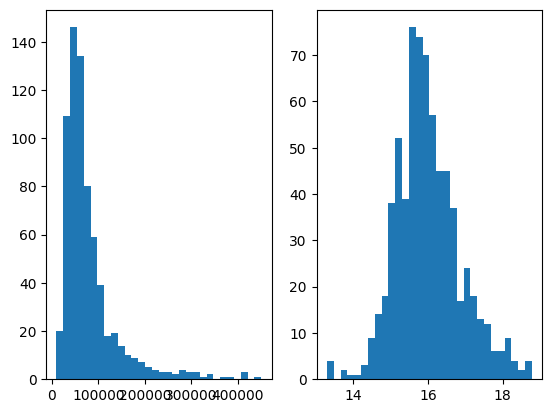

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(conjuntoDadosTreino['price'], bins=30)
ax2.hist(np.log2(conjuntoDadosTreino['price']), bins=30)

In [17]:
conjuntoDadosLOG = conjuntoDadosLimpo
conjuntoDadosLOG['price'] = np.log(conjuntoDadosLimpo['price'])
conjuntoDadosTreinol = conjuntoDadosLOG[:700]
xTreinolog = conjuntoDadosTreinol.drop(["price"], axis=1)
yTreinolog = conjuntoDadosTreinol['price']
conjuntoDadosTestelog = conjuntoDadosLOG[700:]
xTestelog = conjuntoDadosTestelog.drop(["price"], axis=1)
yTestelog = conjuntoDadosTestelog['price']

ridgeLog = model_selection.GridSearchCV(estimator=linear_model.Ridge(), cv=10, param_grid=regularizacaoGrid, return_train_score=True)
ridgeLog.fit(xTreinolog, yTreinolog)

lassoLog = model_selection.GridSearchCV(estimator=linear_model.Lasso(), cv=10, param_grid=regularizacaoGrid, return_train_score=True)
lassoLog.fit(xTreinolog, yTreinolog)

GridSearchCV(cv=10, estimator=Lasso(), param_grid={'alpha': [1, 4, 10, 15, 20]},
             return_train_score=True)

In [18]:
ridgeLog.cv_results_

{'mean_fit_time': array([0.00592263, 0.00532687, 0.00497677, 0.00549645, 0.00590727]),
 'std_fit_time': array([0.00179323, 0.000839  , 0.0007431 , 0.00125959, 0.00128257]),
 'mean_score_time': array([0.0037102 , 0.00330625, 0.00363579, 0.00430572, 0.00335333]),
 'std_score_time': array([0.00084102, 0.00066803, 0.0009378 , 0.00147557, 0.00050185]),
 'param_alpha': masked_array(data=[1, 4, 10, 15, 20],
              mask=[False, False, False, False, False],
        fill_value=999999),
 'params': [{'alpha': 1},
  {'alpha': 4},
  {'alpha': 10},
  {'alpha': 15},
  {'alpha': 20}],
 'split0_test_score': array([0.83872378, 0.82001528, 0.78973279, 0.76995416, 0.75345951]),
 'split1_test_score': array([0.88394208, 0.86818779, 0.84620845, 0.83224761, 0.82072211]),
 'split2_test_score': array([0.79758746, 0.79814258, 0.784701  , 0.77337016, 0.76248406]),
 'split3_test_score': array([0.86252631, 0.8694489 , 0.85636556, 0.84205611, 0.82844401]),
 'split4_test_score': array([0.86932233, 0.86198627, 0

In [19]:
lassoLog.cv_results_

{'mean_fit_time': array([0.0067708 , 0.00543714, 0.01382127, 0.00699682, 0.00621781]),
 'std_fit_time': array([0.00197766, 0.00090528, 0.01239316, 0.00153971, 0.00147166]),
 'mean_score_time': array([0.00355649, 0.00378084, 0.00422552, 0.00333624, 0.00351756]),
 'std_score_time': array([0.00108073, 0.00119755, 0.00141717, 0.00044714, 0.00088716]),
 'param_alpha': masked_array(data=[1, 4, 10, 15, 20],
              mask=[False, False, False, False, False],
        fill_value=999999),
 'params': [{'alpha': 1},
  {'alpha': 4},
  {'alpha': 10},
  {'alpha': 15},
  {'alpha': 20}],
 'split0_test_score': array([0.30589119, 0.3103229 , 0.31749015, 0.32172985, 0.32439411]),
 'split1_test_score': array([0.48474995, 0.48431768, 0.48153131, 0.47725129, 0.47119123]),
 'split2_test_score': array([0.13706796, 0.14641611, 0.1630625 , 0.17483677, 0.18470402]),
 'split3_test_score': array([0.43078071, 0.42249289, 0.40387181, 0.38627501, 0.36677745]),
 'split4_test_score': array([0.32083431, 0.32367272, 0

In [20]:
print("Resultado de lasso em teste: ",metrics.r2_score(yTestelog, lassoLog.predict(xTestelog)))
print("Resultado de ridge em teste: ",metrics.r2_score(yTestelog, ridgeLog.predict(xTestelog)))

Resultado de lasso em teste:  0.31632906823632845
Resultado de ridge em teste:  0.8492995265554584


Como estamos buscando entender quais são as variáveis que mais impactam no preço dos computadores, vamos usar o conjunto de dados, porém agora completo, para treinar os modelos que melhor performaram no treino e se validou no teste, sendo esse o ridge com penalização 1, e com as variáveis respostas transformadas pela função logarítmica.

In [25]:
XConjuntoDadosLOG = conjuntoDadosLOG.drop(["price"], axis=1)
YConjuntoDadosLOG = conjuntoDadosLOG['price']
ridgeLog = linear_model.Ridge(alpha=1)
ridgeLog.fit(XConjuntoDadosLOG, YConjuntoDadosLOG)
ridgeLog.coef_

XConjuntoDadosLOG.iloc[:, ridgeLog.coef_ == np.sort(ridgeLog.coef_)[-1]]
XConjuntoDadosLOG.iloc[:, ridgeLog.coef_ == np.sort(ridgeLog.coef_)[0]]

def variaveisMaisImportantes(conjuntoDados, modelo, qntVariaveis):
    print(f"Os {qntVariaveis} mais importantes para aumentar o preço")
    for i in range(1, qntVariaveis+1):
        print(list(conjuntoDados.iloc[:, modelo.coef_ == np.sort(modelo.coef_)[-i]])[0])

    print(f"\n\nOs {qntVariaveis} mais importantes para baixar o preço")
    for i in range(qntVariaveis):
        print(list(conjuntoDados.iloc[:, modelo.coef_ == np.sort(modelo.coef_)[i]])[0])
variaveisMaisImportantes(XConjuntoDadosLOG, ridgeLog, 5)

Os 5 mais importantes para aumentar o preço
64GB
24 Cores (8P + 16E), 32 Threads
2TB
32GB
16 Cores (8P + 8E), 24 Threads


Os 5 mais importantes para baixar o preço
Dual Core, 2 Threads
ROMOutros
4GB
Dual Core, 4 Threads
Xiaomi
